# Option pricing models

## Introduction

In this project, we will explore various classical methodologies for option pricing by focusing on three models: the Black-Scholes model, the CRR binomial model, and Monte Carlo simulations, incorporating a variance reduction method in the latter. We will develop the corresponding algorithms for both Call and Put options, along with measuring their sensitivities ($\Delta$,$\Gamma$)

In [4]:
# Importing the necessary python libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.stats as stats
import random
from scipy.stats import qmc
from scipy.stats import norm
import math

## Black Scholes model

The Black Scholes option pricing model function needs five input variables that come from  option's conditions:

$\S_{0}$ - The asset underlying price at start 

K - The agreed strike price 

T - Options maturity 

r - risk-free rate 

$\sigma$\;(vol) - asset's volatility 

We can compute either a call or a put, meaning that when purchasing options, you have the right—but not the obligation—to buy (for a call) or sell (for a put) the underlying asset.

The hypotheses underlying the Black–Scholes formula do not align with the reality and therefore the results obtained are not one hundred percent reliable. Assumptions like the efficiency of the market, constant volatility or constant risk free rate are not realistic.

In [6]:
import numpy as np
import math
from scipy.stats import norm

def Black_Scholes_model(K, T, S0, r, vol, opttype="C"):
    """
    Calculates the price, Delta, and Gamma for a European call or put option using the Black-Scholes model.

    Parameters:
    K (float): Strike price of the option
    T (float): Time to maturity (in years)
    S0 (float): Current stock price
    r (float): Risk-free interest rate
    vol (float): Volatility of the stock
    opttype (str): Type of option ('C' for call, 'P' for put). Default is 'C'.

    Returns:
    tuple: A tuple containing the option price, Delta, and Gamma.
    """
    # Calculate the discount factor
    disc = np.exp(-r * T)
    
    # Calculate d1 and d2
    d1 = (np.log(S0 / K) + T * (r + 0.5 * (vol ** 2))) * (1 / (vol * math.sqrt(T)))
    d2 = d1 - (vol * math.sqrt(T))
    
    if opttype == "C":
        # Calculate call option price, Delta, and Gamma
        C = (S0 * norm.cdf(d1)) - (K * disc * norm.cdf(d2))
        Delta = norm.cdf(d1)
        Gamma = (1 / math.sqrt(2 * math.pi)) * math.exp(-d1**2 / 2) * (1 / (S0 * vol * math.sqrt(T)))
        return (C, Delta, Gamma)
    elif opttype == "P":
        # Calculate put option price, Delta, and Gamma
        P = -(S0 * norm.cdf(-d1)) + (K * disc * norm.cdf(-d2))
        Delta = norm.cdf(-d1)
        Gamma = (1 / math.sqrt(2 * math.pi)) * math.exp(-d1**2 / 2) * (1 / (S0 * vol * math.sqrt(T)))
        return (P, Delta, Gamma)


After setting up the function, we plot volatility ($\sigma$) against various measures such as the option price ($V$) and the sensitivieties $\Delta$, and $\Gamma$.

It's interesting to observe that as we simulate higher probabilities, the option price increases linearly with volatility due to the greater risk associated with the investment.

In real-world operations, accurately computing volatility is challenging and remains a topic of ongoing research. The key to successful options trading lies in effectively estimating $\sigma$."

This revision improves flow and corrects minor grammatical issues.

In [7]:
import numpy as np

# Generate arrays of volatility and strike prices
volatility = np.linspace(0.1, 2, 20)
strikeprice = np.linspace(44.5, 84.5, 20)

# Calculate Black-Scholes values for each volatility and strike price
vol_blackscholes = [Black_Scholes_model(64.5, 0.2466, 64.5, 0.02514, vol, "C")[0] for vol in volatility]
Delta = [Black_Scholes_model(64.5, 0.2466, 64.5, 0.02514, vol, "C")[1] for vol in volatility]
Gamma = [Black_Scholes_model(64.5, 0.2466, 64.5, 0.02514, vol, "C")[2] for vol in volatility]

strike_blackscholes_C = [Black_Scholes_model(strike, 0.2466, 64.5, 0.02514, 0.05, "C")[0] for strike in strikeprice]
strike_blackscholes_P = [Black_Scholes_model(strike, 0.2466, 64.5, 0.02514, 0.05, "P")[0] for strike in strikeprice]



In the following graph, we observe the variation in the option price, $\Delta$, and $\Gamma$ with respect to volatility expectations. Clearly, the option price increases as volatility rises, along with our $\Delta$ sensitivity. However, the rate of increase in $\Delta$ sensitivity diminishes as volatility grows, as shown in the $\Gamma$ plot



[Text(0.5, 1.0, 'Volatility vs Gamma'),
 Text(0.5, 0, 'Volatility $\\sigma$'),
 Text(0, 0.5, 'Gamma ($\\Gamma$)')]

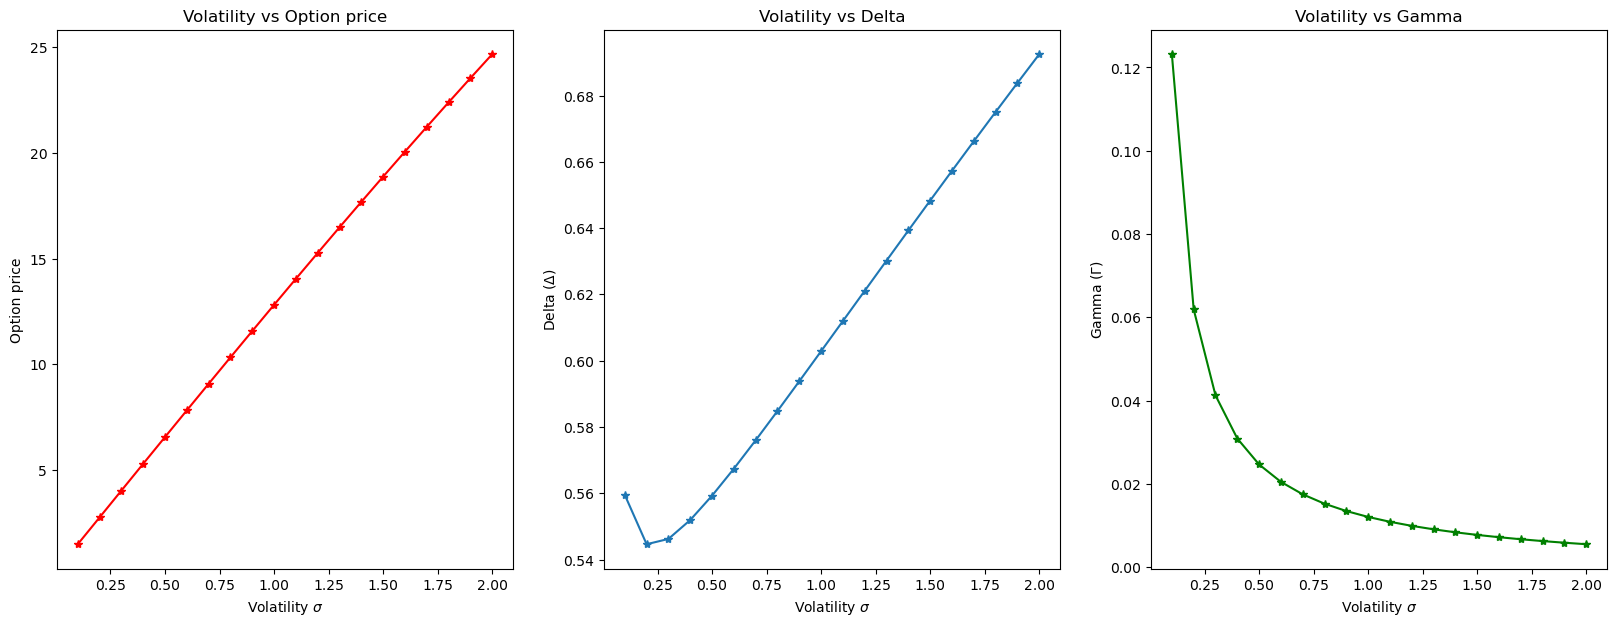

In [8]:
fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(20,7),sharex=True)

ax0.plot(volatility,vol_blackscholes,marker="*",color="red") 
ax0.set(title="Volatility vs Option price",xlabel="Volatility $\sigma$",ylabel="Option price")

ax1.plot(volatility,Delta,marker="*")
ax1.set(title="Volatility vs Delta",xlabel="Volatility $\sigma$",ylabel="Delta ($\Delta$)")

ax2.plot(volatility,Gamma,marker="*",color="green")
ax2.set(title="Volatility vs Gamma",xlabel="Volatility $\sigma$",ylabel="Gamma ($\Gamma$)")

The next graph illustrates the price differences between Out of the Money (OTM), At the Money (ATM), and In the Money (ITM) options. These terms refer to scenarios where the underlying asset's price is greater than, equal to, or less than the strike price for call options, and vice versa for put options. As the option moves further into an ITM position in both cases, we observe a linear increase in price. This is a logical result, as the risk to the option seller (short position) escalates accordingly.

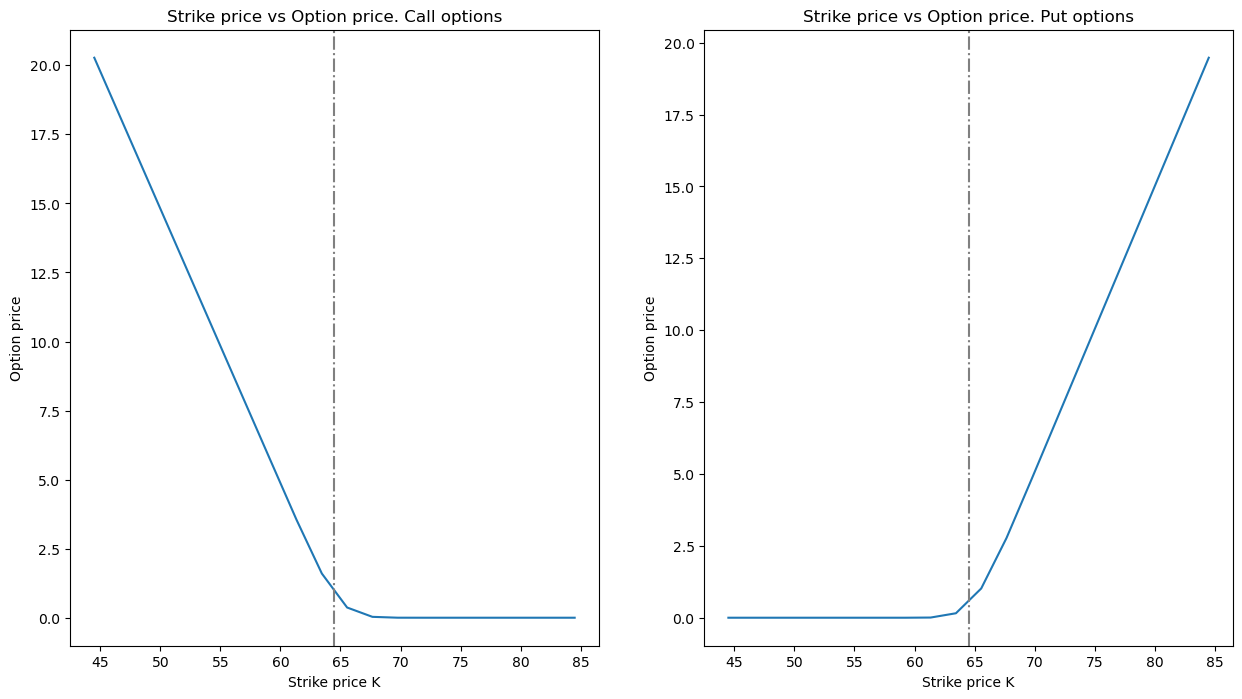

In [9]:
fig,(ax0,ax1)=plt.subplots(1,2,figsize=(15,8))

ax0.plot(strikeprice,strike_blackscholes_C)
ax0.set(title="Strike price vs Option price. Call options",xlabel="Strike price K",ylabel="Option price")
ax0.axvline(64.5,linestyle='-.',color="grey")

ax1.plot(strikeprice,strike_blackscholes_P)
ax1.set(title="Strike price vs Option price. Put options",xlabel="Strike price K",ylabel="Option price")



ax1.axvline(64.5,linestyle='-.',color="grey")

## CRR model

The second option pricing model we will explore is the binomial tree, specifically utilizing the Cox-Ross-Rubinstein (CRR) approach. In this model, the up and down rates are inversely related, represented by 𝑢 = 1/𝑑. However, alternative models may calculate these rates differently.

The function provided below implements the CRR model and requires seven inputs to compute the option price, assuming the up rate is predetermined.

When constructing a binomial tree, the payoff at each node at maturity is calculated using the formula max(𝑆𝑡 − 𝐾, 0) for a call option, or max(𝐾 − 𝑆𝑡, 0) for a put option. The option price is then determined by working backward through the tree, calculating the price at each preceding node based on the values of the subsequent nodes, until reaching the root, where the original option price is obtained. 
We will separate the logic for put and call options into two distinct functions:

In [10]:
import numpy as np

def CRR_put(K, T, S0, r, N,vol):
    """
    Calculate the value of a European put option using the Cox-Ross-Rubinstein (CRR) binomial model.
    
    Parameters:
    K (float): Strike price
    T (float): Time to maturity (years)
    S0 (float): Current stock price
    r (float): Risk-free interest rate
    N (int): Number of steps in the binomial model
    u (float): Up factor
    d (float): Down factor
    
    Returns:
    None (prints the option value, Delta, Theta, and Gamma)
    """
    Gamma = "Not enough steps to approximate $\Gamma$"
    Delta = "Not enough steps to approximate Delta"
    dt = T / N  # Time increment
    u=np.exp(vol*np.sqrt(dt)) #Increase rate
    d=1/u #Decrease rate
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability
    disc = np.exp(-r * dt)  # Discount factor
    
    # Initialize stock prices at maturity
    S = np.zeros(N + 1)
    S[0] = S0 * d**N
    for j in range(1, N + 1):
        S[j] = S[j-1] * u / d
    
    # Initialize option values at maturity
    P = np.zeros(N + 1)
    for j in range(0, N + 1):
        P[j] = max(0, K - S[j])
    
    # Step backwards through the tree
    for i in np.arange(N, 0, -1):
        for j in range(0, i):
            P[j] = disc * ((p * P[j+1]) + ((1 - p) * P[j]))
            if j == 1:
                Delta = (P[1] - P[0]) / ((u - d) * S0)
                Theta = (P[1] - P[0]) / dt
            if j == 2:
                Gamma = ((P[2] - P[1]) / ((S0 * u**2) - (S0 * d * u)) - 
                         (P[1] - P[0]) / ((S0 * u * d - S0 * d**2))) / (S0 * u**2 - S0 * d**2) * 0.5
    
    print('The value of the European put option is: ' + str(P[0]))
    print("Delta: " + str(Delta))
    print("Theta: " + str(Theta))
    print("Gamma: " + str(Gamma))


In [11]:
CRR_put(100,0.274,100,0.03,5,1.045,0.956)

The value of the European put option is: 3.7522268612863265
Delta: -0.453587809337629
Theta: -73.66663326833752
Gamma: 0.010500809303165739


In [45]:
import numpy as np

def CRR_call(K, T, S0, r, N,vol):
    """
    Calculate the value of a European call option using the Cox-Ross-Rubinstein (CRR) binomial model.
    
    Parameters:
    K (float): Strike price
    T (float): Time to maturity (years)
    S0 (float): Current stock price
    r (float): Risk-free interest rate
    N (int): Number of steps in the binomial model
    u (float): Up factor
    d (float): Down factor
    
    Returns:
    None (prints the option value, Delta, Theta, and Gamma)
    """
    Gamma = "Not enough steps to approximate Gamma"
    Delta = "Not enough steps to approximate Delta"
    
    dt = T / N  # Time increment
    u=np.exp(vol*np.sqrt(dt))
    d=1/u
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability
    disc = np.exp(-r * dt)  # Discount factor
    
    # Initialize stock prices at maturity
    S = np.zeros(N + 1)
    S[0] = S0 * d**N
    for j in range(1, N + 1):
        S[j] = S[j-1] * u / d
    
    # Initialize option values at maturity
    C = np.zeros(N + 1)
    for j in range(0, N + 1):
        C[j] = max(0, S[j] - K)
    
    # Step backwards through the tree
    for i in np.arange(N, 0, -1):
        for j in range(0, i):
            C[j] = disc * ((p * C[j+1]) + ((1 - p) * C[j]))
            if j == 1:
                Delta = (C[1] - C[0]) / ((u - d) * S0)
                Theta = (C[1] - C[0]) / dt
            if j == 2:
                Gamma = ((C[2] - C[1]) / ((S0 * u**2) - (S0 * d * u)) - 
                         (C[1] - C[0]) / ((S0 * u * d - S0 * d**2))) / (S0 * u**2 - S0 * d**2) * 0.5
    
    print('The value of the European call option is: ' + str(C[0]))
    print("Delta: " + str(Delta))
    print("Theta: " + str(Theta))
    print("Gamma: " + str(Gamma))


In [13]:
CRR_call(100,0.274,100,0.03,5,1.045,0.956)

The value of the European call option is: 4.5708576791655045
Delta: 0.5464121906623708
Theta: 88.74212585574998
Gamma: 0.01050080930316578


## Monte carlo simulations

This method involves simulating the path of underlying asset prices 𝑁 times with M steps each. The returns of the underlying asset are modeled as a stochastic Geometric Brownian motion, which can be discretized using Itô's formula:

$$\frac{S_{t}}{S_{t-1}}=exp{(r-\frac{\sigma^2}{2})dt+\sigma \sqrt(dt) Z_{t}}\;\;where\;\;\;\; Z_{t}\equiv N(0,1)$$ 
introducing a degree of randomness or white noise


For each simulated path, we compute the option value at T =0

-For a CALL option:

$\hat{C_{j}}=max(\hat{S_{T}}-K,0)\;\; for\;\; j\;\; \in \{1,...N\}$ in case of a CALL option

-For a PUT option:

$\hat{P_{j}}=max(K-\hat{S_{T}},0)\;\; for\;\; j\;\; \in \{1,...N\}$ in case of a PUT option

We will use this trajectories later to compute our final option price


For random normal samples for our white noise using the Box-Muller algorithm. This will involve both random and pseudo-random number generation methods, with a particular focus on the latter, which will be implemented using the Halton sequence for comparison of results.

Here is our underlying asset simulation function. We select the number of steps and iterations, along with the basic inputs for the options. The random number generator can be either Random or Quasi-Random, and we will soon examine the differences in the outcomes produced by each method.

In [ ]:
def Box_Muller(size_=1):
    "Returns a random normal sample of size=2*size"
    U1 = np.random.uniform(size = math.floor(size_) )
    U2 = np.random.uniform(size = math.ceil(size_))
    r = np.sqrt(-2 * np.log(U1))
    Theta = 2 * np.pi * U2
    X_1 = r * np.cos(Theta)
    X_2 = r * np.sin(Theta)
    return np.concatenate((X_1,X_2))

In [16]:
import numpy as np

def mc_asset(S0, r, sigma, T, Nsteps, Nrep, method="Random"):
    """
    Monte Carlo simulation for asset price paths using either random or quasi-random numbers.
    
    Parameters:
    S0 (float): Initial asset price
    r (float): Risk-free rate
    sigma (float): Volatility
    T (float): Time to maturity (years)
    Nsteps (int): Number of time steps
    Nrep (int): Number of simulation paths
    method (str): Random number generation method ("Random" or "Quasi")
    
    Returns:
    np.ndarray: Array containing simulated asset price paths
    """
    # Initialize simulation array
    simulations = np.zeros((Nrep, 1 + Nsteps))
    simulations[:, 0] = S0  # Set initial price
    dt = T / Nsteps  # Time increment
    
    if method == "Random":
        # Perform simulations using random numbers
        for i in range(Nrep):
            for j in range(Nsteps):
                epsilon = np.exp((r - (sigma**2 / 2)) * dt) + (Box_Muller(1)[0] * sigma * np.sqrt(dt))
                simulations[i, j + 1] = epsilon * simulations[i, j]
    elif method == "Quasi":
        # Perform simulations using quasi-random numbers
        for i in range(Nrep):
            for j in range(Nsteps):
                epsilon = np.exp((r - (sigma**2 / 2)) * dt) + (Box_Muller(1, "Quasi")[0] * sigma * np.sqrt(dt))
                simulations[i, j + 1] = epsilon * simulations[i, j]
    
    return simulations


By plotting the paths formed by using normal distributed samples using both random and quasi-random methods , a clear arbitrage in the trajectory emerges with random numbers. In contrast, using the Halton sequence and quasi-random numbers, there's a slight downward trend. This likely results from the regular patterns seen with the Halton sequence and the repeated simulation of evenly spaced numbers along the $[0,1]$ axis. Conclusively random number generation is clearly the preferable option.

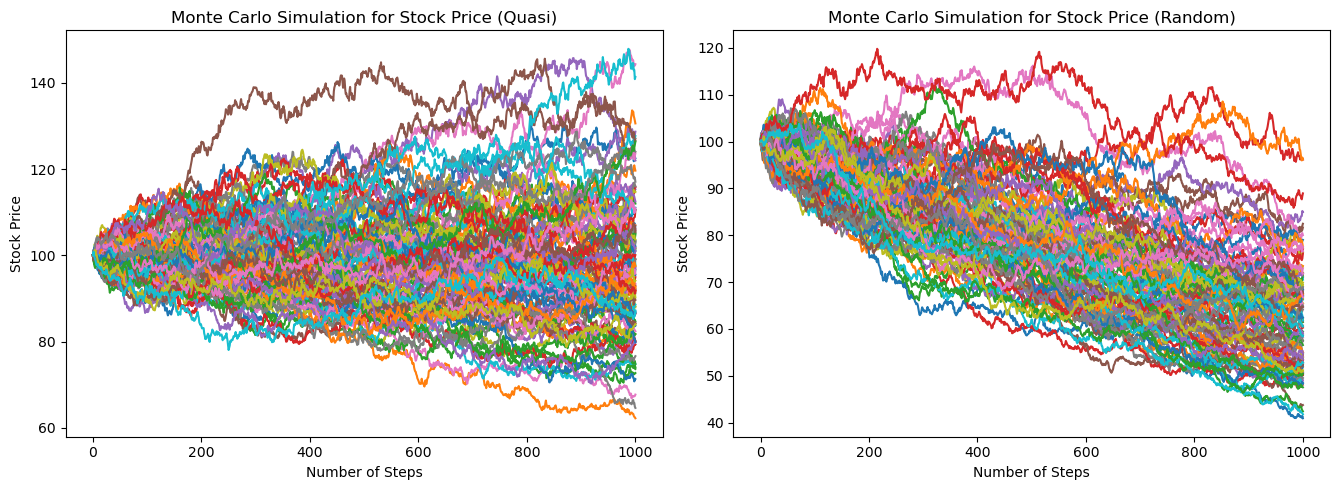

In [17]:
S0 = 100
K = 110
CallOrPut = 'call'
r = 0.03
sigma = 0.25
T = 0.5
Nsteps = 1000
Nrep = 100
PATH_1 = mc_asset(S0, r, sigma, T, Nsteps, Nrep)
PATH_2 = mc_asset(S0, r, sigma, T, Nsteps, Nrep,"Quasi")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.5, 5))

# Plot Quasi-Random Paths
for i in range(len(PATH_1)):
    ax1.plot(PATH_1[i])

ax1.set_xlabel('Number of Steps')  # Corrected to set_xlabel
ax1.set_ylabel('Stock Price')       # Corrected to set_ylabel
ax1.set_title('Monte Carlo Simulation for Stock Price (Quasi)')  # Added title for clarity

# Plot Random Paths
for i in range(len(PATH_2)):
    ax2.plot(PATH_2[i])

ax2.set_xlabel('Number of Steps')  # Corrected to set_xlabel
ax2.set_ylabel('Stock Price')       # Corrected to set_ylabel
ax2.set_title('Monte Carlo Simulation for Stock Price (Random)')  # Added title for clarity

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

As mentioned before, to compute the expected option value, we take the average of the simulated payoffs:

-For a CALL option:

$\hat{E(C)}=\frac{1}{M}\sum{C_{i}}$ CALL

-For a PUT option:

$\hat{E(P)}=\frac{1}{M}\sum{P_{i}}$ PUT

In [75]:
def price_option(K,T,S0,r,vol,Nsteps,Nrep,opttype="C",method="default"):
    if method=="default":
        simulations=mc_asset(S0, r, vol, T, Nsteps, Nrep) 
    if opttype=="C":
        C_i=np.maximum(0,simulations[:,-1]-K)
        return (C_i).mean()*np.exp(-r*T),C_i
    else:
        C_i=np.maximum(0,simulations[:,-1]-K)
        return (P_i).mean()*np.exp(-r*T),P_i

## Variance reduction method. Antithetic variables

Monte Carlo estimation often faces a significant variance influence on the final value, stemming from computing the final parameter through the mean. To address this issue, we can employ various estimation methods, such as antithetic variables, to reduce sample variance and achieve a more realistic and precise estimation.

This method's idea is to produce a price path for the underlying asset while simultaneously creating a path with opposing returns.

$S_{t}^{u}=S_{t-1}exp{(r-\frac{\sigma^2}{2})dt+\sigma \sqrt(dt) Z_{t}}\\$
$S_{t}^{d}=S_{t-1}exp{(r-\frac{\sigma^2}{2})dt-\sigma \sqrt(dt) Z_{t}} \quad \text{where} \quad Z_{t}\equiv N(0,1)$

We can compute both trajectories knowing that their respective covariance is negative, meaning that when calculating the final mean there will be a variance reduction in our final estimator 
$\\\;\hat{C(T,S)}=\frac{\sum{\hat{C}_{j}}}{N}$ 
$\\\;\hat{P(T,S)}=\frac{\sum{\hat{P}_{j}}}{N}$


In [73]:
def mc_asset_antithetic(S0, mean, sigma, T, Nsteps, Nrep):
    """
    Monte Carlo simulation for asset price paths using antithetic variates method.
    
    Parameters:
    S0 (float): Initial asset price
    mean (float): Mean of the normal distribution
    sigma (float): Volatility
    T (float): Time to maturity (years)
    Nsteps (int): Number of time steps
    Nrep (int): Number of simulation paths
    
    Returns:
    np.ndarray: Array containing simulated asset price paths using antithetic variates
    """
    # Initialize simulation arrays
    simulations = np.zeros((Nrep, 1 + Nsteps))
    simulations_ = np.zeros((Nrep, 1 + Nsteps))
    simulations[:, 0] = S0
    simulations_[:, 0] = S0
    dt = T / Nsteps  # Time increment 
    
    # Perform simulations
    for i in range(Nrep):
        for j in range(Nsteps):                                # Calculate epsilon and antithetic epsilon
            epsilon = np.exp((r - (sigma**2 / 2)) * dt) + (Box_Muller(1)[0] * sigma * np.sqrt(dt))
            epsilon_ = np.exp((r - (sigma**2 / 2)) * dt) - (Box_Muller(1)[0] * sigma * np.sqrt(dt))
            simulations[i, j + 1] = epsilon * simulations[i, j]
            simulations_[i, j + 1] = epsilon_ * simulations[i, j]
    return np.concatenate((simulations, simulations_))           # Combine simulations and antithetic simulations


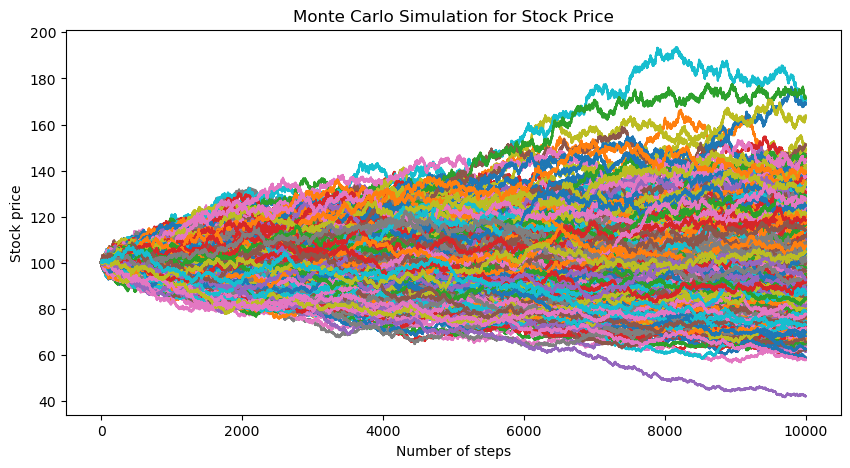

In [20]:
S0 = 100          # Initial stock price
K = 110           # Strike price
CallOrPut = 'call' # Option type
r = 0.03          # Risk-free rate
sigma = 0.25      # Volatility
T = 0.5           # Time to maturity
Nsteps = 10000    # Number of time steps
Nrep = 1000      # Number of simulation paths

# Generate asset price paths using antithetic variables method
PATH = mc_asset_antithetic(S0, r, sigma, T, Nsteps, Nrep)

# Plot the simulated paths
plt.figure(figsize=(10,5))  # Set the figure size
for j in range(len(PATH)):
    plt.plot(PATH[j])       # Plot each path
plt.xlabel('Number of steps')   # Label for x-axis
plt.ylabel('Stock price')       # Label for y-axis
plt.title('Monte Carlo Simulation for Stock Price')  # Title of the plot
plt.show()  # Display the plot


Finally, to compute the expected option value, we take the average of the simulated payoffs:

$\hat{E}[C]=\frac{1}{M}\sum{C_{i}}=\hat{C}(T,S)$  for a CALL option

$\hat{E}[P]=\frac{1}{M}\sum{P_{i}}=\hat{P}(T,S)$ for a PUT option 

In [77]:
def price_option(K, T, S0, r, sigma, Nsteps, Nrep, opttype="C", method="default"):
    """
    Price an option using Monte Carlo simulation.
    
    K: Strike price
    T: Time to maturity
    S0: Initial stock price
    r: Risk-free rate
    sigma: Volatility
    Nsteps: Number of time steps
    Nrep: Number of simulations
    opttype: 'C' for call, 'P' for put (default 'C')
    method: 'default' or 'antithetic' for variance reduction
    
    Returns: (option price, simulated payoffs)
    """
    if method == "default":
        simulations = mc_asset(S0, r, sigma, T, Nsteps, Nrep)
    elif method == "antithetic":
        simulations = mc_asset_antithetic(S0, r, sigma, T, Nsteps, Nrep)
    if opttype == "C":
        C_i = np.maximum(0, simulations[:, -1] - K)
        return C_i.mean() * np.exp(-r * T), C_i
    else:
        P_i = np.maximum(0, K - simulations[:, -1])
        return P_i.mean() * np.exp(-r * T), P_i


We calculate the difference in the estimated standard error between a Monte Carlo simulation with and without antithetic variates to highlight the key distinctions. Additionally, we compute the confidence interval, assuming the simulations follow a normal distribution. With $\sigma_{c}$ STD of the $\{C_{i}\}$ is:

$$standard error=\frac{\sigma_{C}}{M}$$

In [22]:
C_hat,C_i=price_option(K,T,S0,r,sigma,Nsteps,2*Nrep,"C")
C_hat

3.5280845813041837

In [23]:
std_C=np.std(C_i)/np.sqrt(2*Nrep)
IC=[C_hat+(stats.norm.ppf(0.05)*std_C),C_hat+(stats.norm.ppf(0.95)*std_C)]

In [24]:
IC,std_C

([3.216793672604582, 3.8393754900037855], 0.18925143465594568)

As we can see the variance reduction is clear. We have to simulate 

In [25]:
C_hat_ant,C_i_ant=price_option(K,T,S0,r,sigma,Nsteps,Nrep,"C","antithetic")
C_hat_ant

3.0517682354393902

In [26]:
std_C_ant=np.std(C_i_ant)/np.sqrt(2*Nrep)
IC_ant=[C_hat_ant+(stats.norm.ppf(0.05)*std_C_ant),C_hat_ant+(stats.norm.ppf(0.95)*std_C_ant)]
IC_ant,std_C_ant

([2.7694728838485094, 3.334063587030271], 0.17162338761661078)

## Performance with real world examples

We will now compare our model results with real-life options. Although dividend payments should be considered, we have not accounted for them in our models, despite the availability of methods to do so. For this comparison, we will use an Albemarle Corporation call option and attempt to accurately price it using the three models previously discussed.


As we can see, in this particular case, the performance of our models is satisfactory, as the estimated prices are relatively close to both the bid and ask prices of the real option:
- Bid price: 23.7 \$
- Asked price: 25.65$
- Black Scholes model price :22.63 \$
- CRR model price: 22.55 \$
- Montecarlo simulation price: 17.68 \$

Based on the results of our models, we can conclude that the option appears to be slightly overpriced.


In [91]:
# Replace 'ALB' with the ticker you're interested in
ticker_symbol = 'ALB'

# Fetch the data
ticker = yf.Ticker(ticker_symbol)

# Get stock price and dividend yield
stock_price = ticker.history(period="1d")['Close'][0]
#dividend_yield = ticker.info['dividendyield']  # This might be None if the stock doesn't pay dividends

# Fetch option chains as before
options_dates = ticker.options
all_options = pd.DataFrame()

for date in options_dates:
    opt = ticker.option_chain(date)
    calls = opt.calls
    calls['Expiry'] = date
    calls['Type'] = 'Call'

    puts = opt.puts
    puts['Expiry'] = date
    puts['Type'] = 'Put'

    options = pd.concat([calls, puts])
    all_options = pd.concat([all_options, options])

# Add additional columns
all_options['Date'] = datetime.now().strftime('%Y-%m-%d')
all_options['Expiry'] = pd.to_datetime(all_options['Expiry'])
all_options['Days to Expiration'] = (all_options['Expiry'] - pd.to_datetime(all_options['Date'])).dt.days

# Add stock price and dividend yield to each row (these values are constant for this snapshot)
all_options['Stock Price'] = stock_price

all_options.iloc[3,:]

contractSymbol               ALB241025C00078000
lastTradeDate         2024-09-11 19:12:37+00:00
strike                                     78.0
lastPrice                                  14.0
bid                                        23.7
ask                                       25.65
change                                      0.0
percentChange                               0.0
volume                                      8.0
openInterest                                  4
impliedVolatility                      6.133791
inTheMoney                                 True
contractSize                            REGULAR
currency                                    USD
Expiry                      2024-10-25 00:00:00
Type                                       Call
Date                                 2024-10-24
Days to Expiration                            1
Stock Price                           93.959999
Name: 3, dtype: object

In [94]:
S0=93.95999
K=78
r=0.05
T=1/252
r=0.055 # U.S treasury rate we will use as free interest rate
vol=6.133791
N=20
Nsteps=100
Nrep=1000
Black_Scholes_model(K,T,S0,r,vol,opttype="C")

(22.638059664413255, 0.7503372994976819, 0.008746593269364571)

In [95]:
CRR_call(K,T,S0,r,N,vol)

The value of the European call option is: 22.55851920470794
Delta: 0.7520091498858611
Theta: 61614.15855775316
Gamma: 0.00224168432586704


In [96]:
C,C_i=price_option(K,T,S0,r,vol,Nsteps,Nrep,"C","default")
C_ant,C_ant_i=price_option(K,T,S0,r,vol,Nsteps,Nrep,"C","antithetic")
(C,C_ant)

(17.78054644254415, 19.25594839403814)